In [104]:
import numpy as np
import matplotlib.pyplot as plt
import datetime
import scipy.fftpack

import tensorflow as tf
from tensorflow import keras

#Set the seed for reproductability
np.random.seed(0)

### Define the NN - a simple Multi Layer Perceptron with 3 layers


In [105]:
# Time series prediction model
def simpleMLP_model():
  model = keras.Sequential([
    keras.layers.Dense(64, activation=tf.nn.relu,
                       input_shape=(train_data.shape[1],)),
    keras.layers.Dense(32, activation=tf.nn.relu),
    keras.layers.Dense(8, activation=tf.nn.relu),
    keras.layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.Adam()
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae'])
  model.summary()
  return model

def simple_LSTM_model():
    model = keras.Sequential([
    keras.layers.LSTM(64, input_shape=(64, 1)),
    # keras.layers.BatchNormalization(),
    keras.layers.Dense(32, activation=tf.nn.relu),
    # keras.layers.Dense(8, activation=tf.nn.relu),
    keras.layers.Dense(1)
    ])
    optimizer = tf.keras.optimizers.Adam()
    model.compile(loss='mse',
                  optimizer=optimizer,
                  metrics=['mae'])
    model.summary()
    return model

def simple_RNN_model():
    model = keras.Sequential([
    keras.layers.SimpleRNN(64, input_shape=(64, 1)),
    # keras.layers.BatchNormalization(),
    keras.layers.Dense(32, activation=tf.nn.relu),
    # keras.layers.Dense(8, activation=tf.nn.relu),
    keras.layers.Dense(1)
    ])
    optimizer = tf.keras.optimizers.Adam()
    model.compile(loss='mse',
                  optimizer=optimizer,
                  metrics=['mae'])
    model.summary()
    return model

Create data

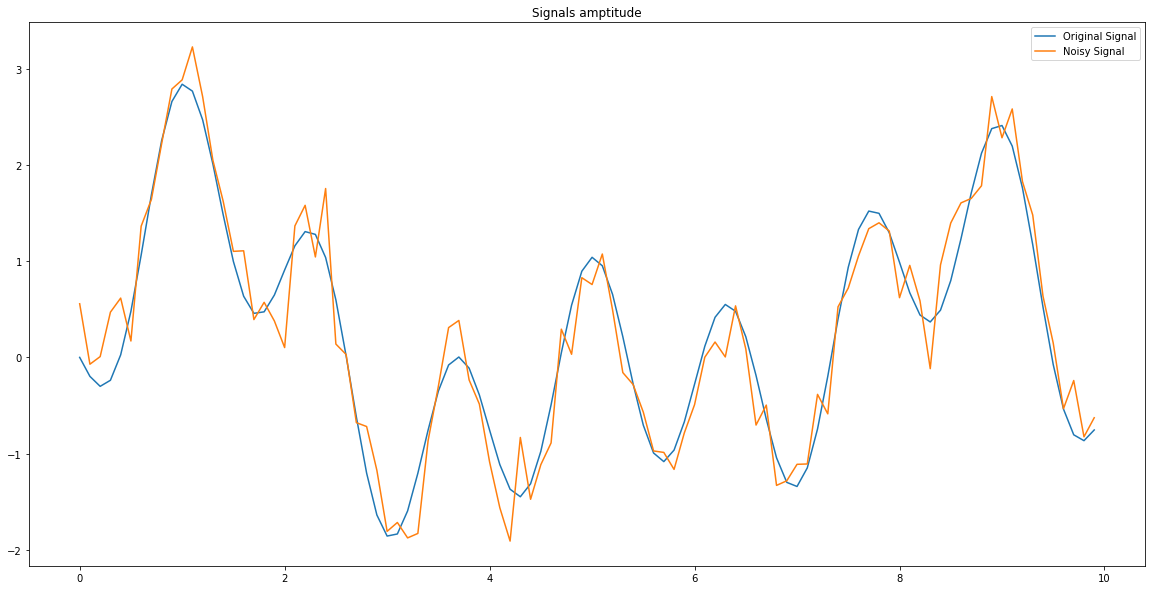

In [106]:
num_train_data = 4000
num_test_data = 1000
timestep = 0.1
tm =  np.arange(0, (num_train_data+num_test_data)*timestep, timestep)
#The original signal
y = np.sin(tm) + np.sin(tm*np.pi/2) + np.sin(tm*(-3*np.pi/2))
# y = np.sin(tm)

SNR = 10
# SNR = 30
# The noise signal
ypn = y + np.random.normal(0,10**(-SNR/20),len(y))

fix, ax = plt.subplots(figsize=(20,10))
ax.plot(tm[0:100],y[0:100], label='Original Signal')
ax.plot(tm[0:100],ypn[0:100], label='Noisy Signal')
ax.set_title('Signals amptitude')
ax.legend()

In [107]:
# prepare the train_data and train_labels
dnn_numinputs = 64
num_train_batch = 0
train_data = []
for k in range(num_train_data-dnn_numinputs-1):
  train_data = np.concatenate((train_data,ypn[k:k+dnn_numinputs]))
  num_train_batch = num_train_batch + 1
train_data = np.reshape(train_data, (num_train_batch,dnn_numinputs))
train_labels = y[dnn_numinputs:num_train_batch+dnn_numinputs]

# We need to reshape our data for LSTM
train_data_lstm = train_data.reshape(train_data.shape[0],train_data.shape[1],1)
print(train_data_lstm.shape)
print(train_data.shape, train_labels.shape, y.shape, ypn.shape)

(3935, 64, 1)
(3935, 64) (3935,) (5000,) (5000,)


Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_63 (Dense)            (None, 64)                4160      
                                                                 
 dense_64 (Dense)            (None, 32)                2080      
                                                                 
 dense_65 (Dense)            (None, 8)                 264       
                                                                 
 dense_66 (Dense)            (None, 1)                 9         
                                                                 
Total params: 6,513
Trainable params: 6,513
Non-trainable params: 0
_________________________________________________________________
DNN training done. Time elapsed:  14.384246 s


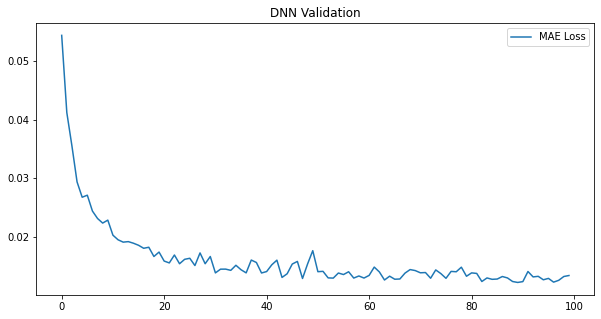

In [108]:
dnn_model = simpleMLP_model()

EPOCHS = 100
strt_time = datetime.datetime.now()
dnn_history = dnn_model.fit(train_data, train_labels, epochs=EPOCHS,
                  validation_split=0.2, verbose=0,
                  callbacks=[])

curr_time = datetime.datetime.now()
timedelta = curr_time - strt_time
dnn_train_time = timedelta.total_seconds()

print("DNN training done. Time elapsed: ", timedelta.total_seconds(), "s")

fix, ax = plt.subplots(figsize=(10,5))
ax.plot(dnn_history.epoch, np.array(dnn_history.history['val_loss']), label = 'MAE Loss')
ax.set_title('DNN Validation')
ax.legend()


Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_7 (SimpleRNN)    (None, 64)                4224      
                                                                 
 dense_67 (Dense)            (None, 32)                2080      
                                                                 
 dense_68 (Dense)            (None, 1)                 33        
                                                                 
Total params: 6,337
Trainable params: 6,337
Non-trainable params: 0
_________________________________________________________________
RNN training done. Time elapsed:  72.032505 s


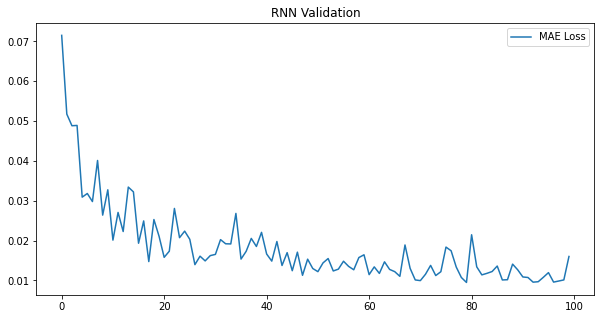

In [109]:
rnn_model = simple_RNN_model()

EPOCHS = 100
strt_time = datetime.datetime.now()
rnn_history = rnn_model.fit(train_data_lstm, train_labels, epochs=EPOCHS,
                  validation_split=0.2, verbose=0,
                  callbacks=[])

curr_time = datetime.datetime.now()
timedelta = curr_time - strt_time
dnn_train_time = timedelta.total_seconds()

print("RNN training done. Time elapsed: ", timedelta.total_seconds(), "s")

fix, ax = plt.subplots(figsize=(10,5))
ax.plot(rnn_history.epoch, np.array(rnn_history.history['val_loss']), label = 'MAE Loss')
ax.set_title('RNN Validation')
ax.legend()


Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_15 (LSTM)              (None, 64)                16896     
                                                                 
 dense_69 (Dense)            (None, 32)                2080      
                                                                 
 dense_70 (Dense)            (None, 1)                 33        
                                                                 
Total params: 19,009
Trainable params: 19,009
Non-trainable params: 0
_________________________________________________________________
LSTM training done. Time elapsed:  173.759152 s


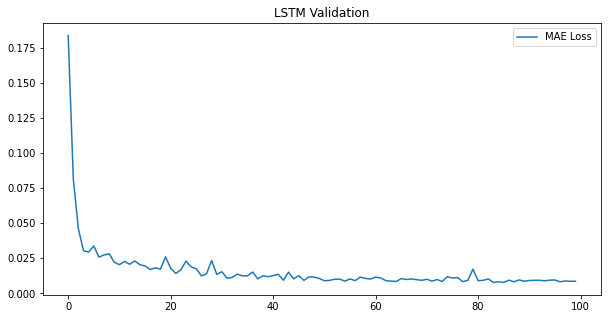

In [110]:
lstm_model = simple_LSTM_model()

EPOCHS = 100
strt_time = datetime.datetime.now()

lstm_history = lstm_model.fit(train_data_lstm, train_labels, epochs=EPOCHS,
                  validation_split=0.2, verbose=0,
                  callbacks=[])

curr_time = datetime.datetime.now()
timedelta = curr_time - strt_time
dnn_train_time = timedelta.total_seconds()

print("LSTM training done. Time elapsed: ", timedelta.total_seconds(), "s")

fix, ax = plt.subplots(figsize=(10,5))
ax.plot(lstm_history.epoch, np.array(lstm_history.history['val_loss']), label = 'MAE Loss')
ax.set_title('LSTM Validation')
ax.legend()

Compare Different Neural Network Training statistics

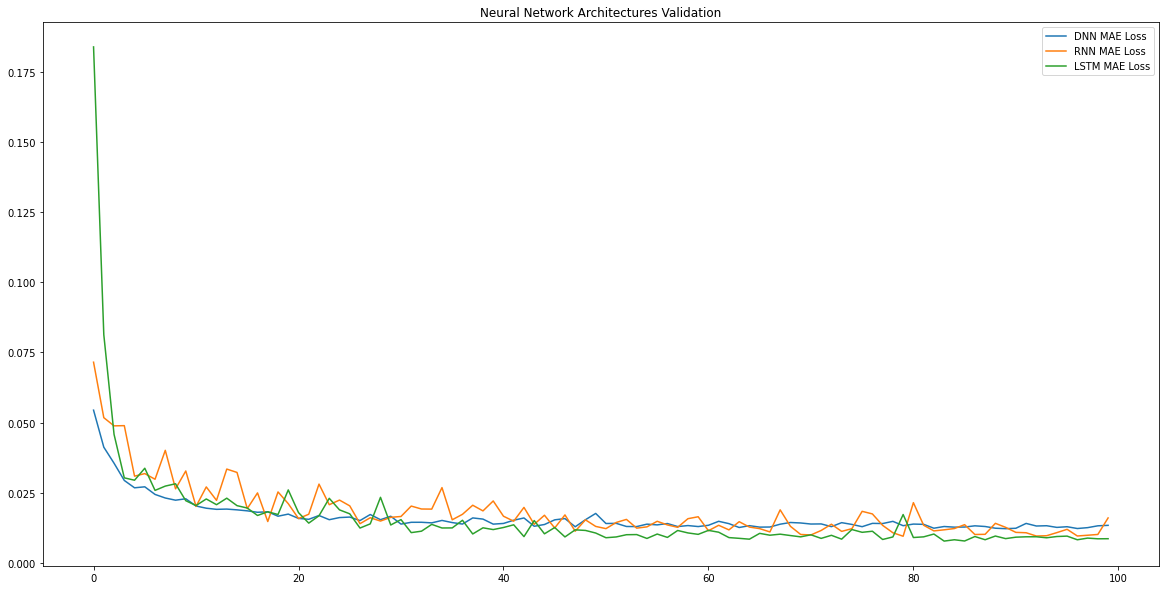

In [111]:
fix, ax = plt.subplots(figsize=(20,10))
ax.plot(dnn_history.epoch, np.array(dnn_history.history['val_loss']), label = 'DNN MAE Loss')
ax.plot(rnn_history.epoch, np.array(rnn_history.history['val_loss']), label = 'RNN MAE Loss')
ax.plot(lstm_history.epoch, np.array(lstm_history.history['val_loss']), label = 'LSTM MAE Loss')
ax.set_title('Neural Network Architectures Validation')
ax.legend()

(935, 64) (935,)
30/30 [==============================] - 0s 7ms/step


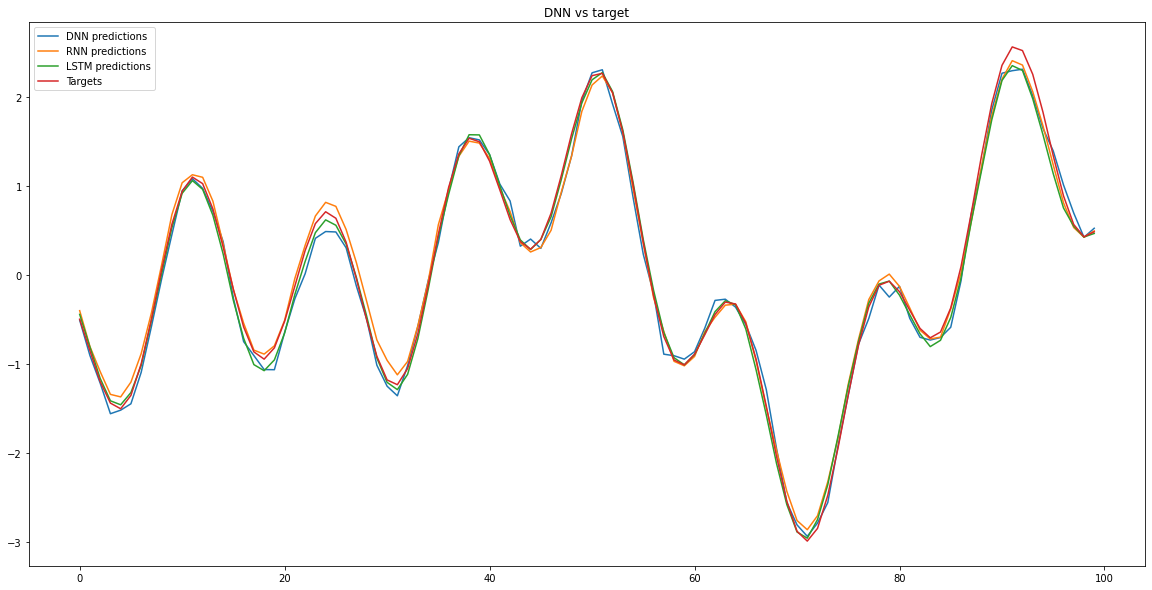

In [112]:
# test how well DNN predicts now
num_test_batch = 0
strt_idx = num_train_batch
test_data=[]
for k in range(strt_idx, strt_idx+num_test_data-dnn_numinputs-1):
  test_data = np.concatenate((test_data,ypn[k:k+dnn_numinputs]))
  num_test_batch = num_test_batch + 1
test_data = np.reshape(test_data, (num_test_batch, dnn_numinputs))
test_labels = y[strt_idx+dnn_numinputs:strt_idx+num_test_batch+dnn_numinputs]

print(test_data.shape, test_labels.shape)


dnn_predictions = dnn_model.predict(test_data).flatten()
rnn_predictions = rnn_model.predict(test_data).flatten()
lstm_predictions = lstm_model.predict(test_data).flatten()
keras_dnn_err = test_labels - dnn_predictions

fix, ax = plt.subplots(figsize=(20,10))
ax.plot(dnn_predictions[0:100], label='DNN predictions')
ax.plot(rnn_predictions[0:100], label='RNN predictions')
ax.plot(lstm_predictions[0:100], label='LSTM predictions')
ax.plot(test_labels[0:100], label='Targets')
ax.set_title('DNN vs target')
ax.legend()


Least Mean Squares (LMS filter) & Linear Regression algorithm

(64,) (1064,) (5000,)
(1064,)
(1064,)


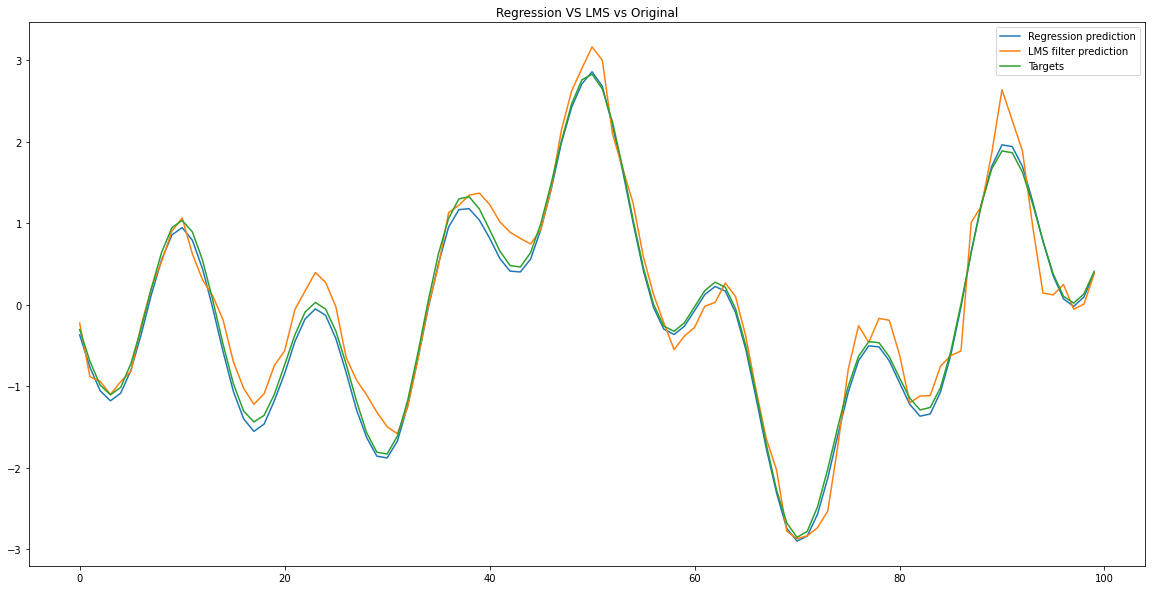

In [113]:
M = 1000
L = 64
yrlms = np.zeros(M+L)
m, c = np.zeros(M+L), np.zeros(M+L)
#wn = np.random.normal(0,1,L)
wn = np.zeros(L)
print(wn.shape, yrlms.shape, y.shape)
mu = 0.005
for k in range(L,M+L):
  yrlms[k] = np.dot(ypn[k-L:k],wn)
  e = ypn[k]- yrlms[k]
  wn=wn+(mu*ypn[k-L:k]*e)

print(yrlms.shape)

# Solve y = mx + c => y = Ap , A = [[x 1]] & p = [[m], [c]]
A = np.zeros(M+L)
for k in range(L,M+L):
  A = np.vstack([y[k-L:k], np.ones(len(y[k-L:k]))]).T
  # print(A.shape, y[k-L:k].shape)
  m[k], c[k] = np.linalg.lstsq(A, ypn[k-L:k], rcond=None)[0]

def prediction(x, m, c):
  return m*x + c

preds = prediction(y[0:M+L], m, c)
print(preds.shape)

fix, ax = plt.subplots(figsize=(20,10))
ax.plot(preds[600:700], label='Regression prediction')
ax.plot(yrlms[600:700], label='LMS filter prediction')
ax.plot(y[600:700], label='Targets')
ax.set_title('Regression VS LMS vs Original')
ax.legend()

Compare Prediction results


Make a **ratio** between signal power and noise power called **SNR**: 

$$SNR = \frac{P_{signal}}{P_{noise}}$$

We need to measure the power $$P(x)$$ of a signal $$x(n)$$ via:

$$ P(x) = \frac{1}{N} \sum_{n=0}^{N-1}x(n)^2$$

Then SNR can be calculated bia the power rations: $$SNR = \frac{P_{signal}}{P_{noise}}$$

If we want to have the values in dB we need to use: 

$$ P_{db} = 10 log_{10} (P)$$ 
so 
$$SNR_{db} = 10 log_{10}(\frac{P_{signal}}{P_{noise}})$$

We calculate the Signal to Noise Ratio SNR in dB:

$$SNR_{db} = 10*log_{10}(\frac{P_{signal}}{P_{noise}}) = 10*log_{10}(P_{signal}) - 10*log_{10}(P_{noise}) = \\ 10*log_{10}\frac{1}{N}\sum|target|^2 - 10* log_{10} \frac{1}{N}\sum |pred - target|^2$$

*Usefull [resource](https://github.com/hrtlacek/SNR/blob/main/SNR.ipynb)

In [114]:
def calc_SNRdb(signal, noise):
    return (10*np.log10(np.mean(pow(np.abs(signal),2))) - 10*np.log10(np.mean(pow(np.abs(noise),2))) )

(935,) (935,)
DNN Prediction SNR: 20.340830726853017
RNN Prediction SNR: 19.9856446873992
LSTM Prediction SNR: 22.585746137798587
Regression Prediction SNR: 11.895216096887026
LMS filter Prediction SNR: 9.576865581533479


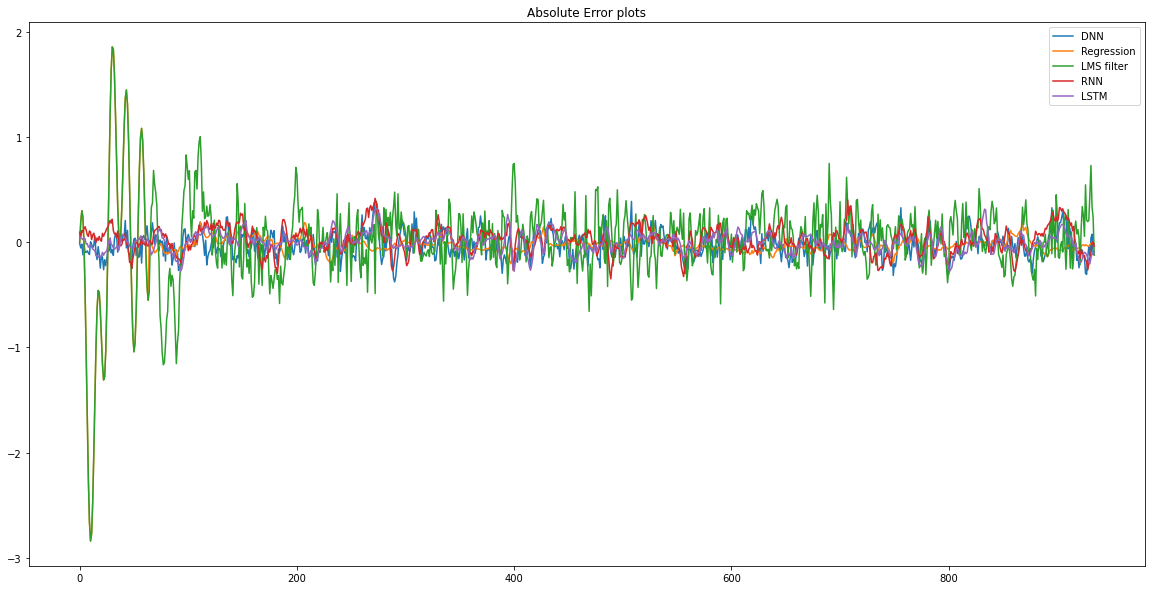

In [115]:
dnn_err = dnn_predictions - test_labels
rnn_err = rnn_predictions - test_labels
lstm_err = lstm_predictions - test_labels
lms_filt_err = yrlms[0:M-65] - y[0:M-65]
lms_err = preds[0:M-65] - y[0:M-65]
print(dnn_err.shape, lms_err.shape)

fix, ax = plt.subplots(figsize=(20,10))
ax.plot(dnn_err, label='DNN')
ax.plot(lms_err, label='Regression')
ax.plot(lms_filt_err, label='LMS filter')
ax.plot(rnn_err, label='RNN')
ax.plot(lstm_err, label='LSTM')
ax.set_title('Absolute Error plots')
ax.legend()

dnn_mse = 10*np.log10(np.mean(pow(np.abs(dnn_err),2)))
dnn_sigpow = 10*np.log10(np.mean(pow(np.abs(test_labels),2)))


lms_mse = 10*np.log10(np.mean(pow(np.abs(lms_err),2)))
lms_sigpow = 10*np.log10(np.mean(pow(np.abs(y[0:M-65]),2)))

#print(dnn_mse, dnn_sigpow, lms_mse, lms_sigpow)
print("DNN Prediction SNR:", calc_SNRdb(test_labels, dnn_err))
print("RNN Prediction SNR:", calc_SNRdb(test_labels, rnn_err))
print("LSTM Prediction SNR:", calc_SNRdb(test_labels, lstm_err))
print("Regression Prediction SNR:", lms_sigpow - lms_mse)
print("LMS filter Prediction SNR:", calc_SNRdb(test_labels, lms_filt_err))

Fast Fourier Transform 

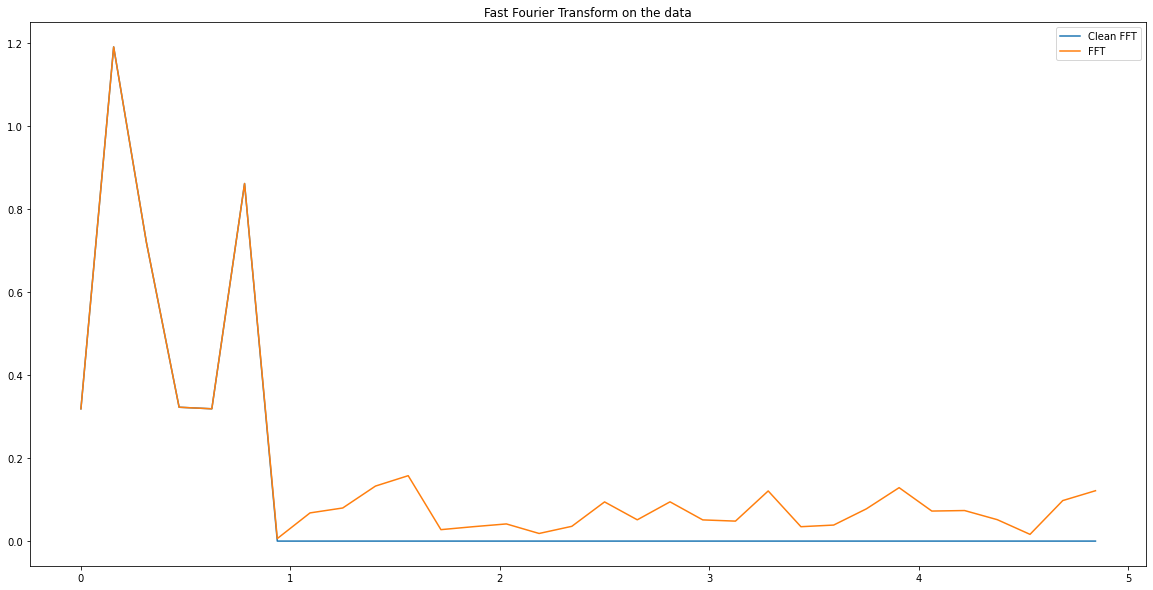

In [116]:
# 64 point FFT
N = 64

# Using the same noisy signal used for LMS
yf = scipy.fftpack.fft(ypn[0:N])

# Let us remove noise, easy to do at the FFT output
y_clean = np.zeros(N,dtype=complex)
cidx = np.where(np.abs(yf)>(N*0.2/2))[0]
y_clean[cidx]=yf[cidx]

# 0 to Fs/2, Fs = 1/Ts
# xf = np.linspace(0.0, 1.0/(2*timestep), int(N/2))
xf = scipy.fftpack.fftfreq(N, timestep)[:N // 2]

# Plotting only from 0 to Fs/2
fix, ax = plt.subplots(figsize=(20,10))
ax.plot(xf, 2.0/N * np.abs(y_clean[:N//2]), label = 'Clean FFT')
ax.plot(xf, 2.0/N * np.abs(yf[:N//2]), label = 'FFT')
ax.set_title('Fast Fourier Transform on the data')
ax.legend()

In [130]:
def simple_MLPFFT_model():
  model = keras.Sequential([
    keras.layers.Dense(NFFT*2, activation=tf.nn.relu,
                       input_shape=(train_data.shape[1],)),
    keras.layers.Dense(NFFT*2, activation=tf.nn.relu),
    keras.layers.Dense(NFFT*2)
  ])
  optimizer = tf.keras.optimizers.Adam()
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae']) 
  model.summary()
  return model

def simple_LSTMFFT_model():
    model = keras.Sequential([
    keras.layers.LSTM(NFFT*2, input_shape=(128, 1)),
    # keras.layers.BatchNormalization(),
    # keras.layers.Dense(NFFT*2, activation=tf.nn.relu),
    keras.layers.LSTM(NFFT*2),
    # keras.layers.Dense(8, activation=tf.nn.relu),
    keras.layers.Dense(NFFT*2)
    ])
    optimizer = tf.keras.optimizers.Adam()
    model.compile(loss='mse',
                  optimizer=optimizer,
                  metrics=['mae'])
    model.summary()
    return model

def simple_RNNFFT_model():
    model = keras.Sequential([
    keras.layers.SimpleRNN(NFFT*2, input_shape=(128, 1)),
    # keras.layers.BatchNormalization(),
    keras.layers.Dense(NFFT*2, activation=tf.nn.relu),
    # keras.layers.Dense(8, activation=tf.nn.relu),
    keras.layers.Dense(NFFT*2)
    ])
    optimizer = tf.keras.optimizers.Adam()
    model.compile(loss='mse',
                  optimizer=optimizer,
                  metrics=['mae'])
    model.summary()
    return model

Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_71 (Dense)            (None, 128)               16512     
                                                                 
 dense_72 (Dense)            (None, 128)               16512     
                                                                 
 dense_73 (Dense)            (None, 128)               16512     
                                                                 
Total params: 49,536
Trainable params: 49,536
Non-trainable params: 0
_________________________________________________________________
DNN training done. Time elapsed:  34.054035 s


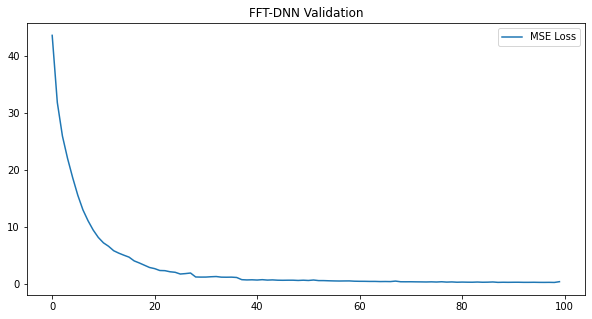

In [118]:
# Train the DNN for 16 point FFT
NFFT = 64
num_train_batch = 1
num_batches = 10000
train_data = np.random.normal(0,1,(num_batches, NFFT*2))
train_labels = np.random.normal(0,1,(num_batches, NFFT*2))
dnnfft_model = simple_MLPFFT_model()
for k in range(num_train_batch):
  for el in range(num_batches):
    fftin = train_data[el,0::2] + 1j*train_data[el,1::2]
    train_labels[el,0::2]=scipy.fftpack.fft(fftin).real
    train_labels[el,1::2]=scipy.fftpack.fft(fftin).imag
  EPOCHS = 100
  strt_time = datetime.datetime.now()
  dnnfft_history = dnnfft_model.fit(train_data, train_labels, epochs=EPOCHS,
                    validation_split=0.2, verbose=0,
                    callbacks=[])
  curr_time = datetime.datetime.now()
  timedelta = curr_time - strt_time
  dnn_train_time = timedelta.total_seconds()
  print("DNN training done. Time elapsed: ", timedelta.total_seconds(), "s")

  fix, ax = plt.subplots(figsize=(10,5))
  ax.plot(dnnfft_history.epoch, np.array(dnnfft_history.history['val_loss']), label = 'MSE Loss')
  ax.set_title('FFT-DNN Validation')
  ax.legend()

  train_data = np.random.normal(0,1,(num_batches, NFFT*2))

Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_8 (SimpleRNN)    (None, 128)               16640     
                                                                 
 dense_74 (Dense)            (None, 128)               16512     
                                                                 
 dense_75 (Dense)            (None, 128)               16512     
                                                                 
Total params: 49,664
Trainable params: 49,664
Non-trainable params: 0
_________________________________________________________________
DNN training done. Time elapsed:  445.049315 s


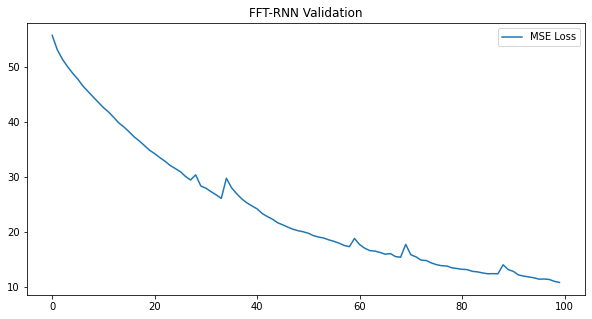

In [119]:
# Train the RNN for 16 point FFT
NFFT = 64
num_train_batch = 1
num_batches = 10000
train_data = np.random.normal(0,1,(num_batches, NFFT*2))
train_data_lstm = train_data.reshape(train_data.shape[0],train_data.shape[1],1)
train_labels = np.random.normal(0,1,(num_batches, NFFT*2))
rnnfft_model = simple_RNNFFT_model()
for k in range(num_train_batch):
  for el in range(num_batches):
    fftin = train_data[el,0::2] + 1j*train_data[el,1::2]
    train_labels[el,0::2]=scipy.fftpack.fft(fftin).real
    train_labels[el,1::2]=scipy.fftpack.fft(fftin).imag
  EPOCHS = 100
  strt_time = datetime.datetime.now()
  rnnfft_history = rnnfft_model.fit(train_data_lstm, train_labels, epochs=EPOCHS,
                    validation_split=0.2, verbose=0,
                    callbacks=[])
  curr_time = datetime.datetime.now()
  timedelta = curr_time - strt_time
  dnn_train_time = timedelta.total_seconds()
  print("DNN training done. Time elapsed: ", timedelta.total_seconds(), "s")

  fix, ax = plt.subplots(figsize=(10,5))
  ax.plot(rnnfft_history.epoch, np.array(rnnfft_history.history['val_loss']), label = 'MSE Loss')
  ax.set_title('FFT-RNN Validation')
  ax.legend()

  train_data = np.random.normal(0,1,(num_batches, NFFT*2))
  train_data_lstm = train_data.reshape(train_data.shape[0],train_data.shape[1],1)

In [131]:
# Train the LSTM for 16 point FFT
NFFT = 64
num_train_batch = 1
num_batches = 10000
train_data = np.random.normal(0,1,(num_batches, NFFT*2))
train_data_lstm = train_data.reshape(train_data.shape[0],train_data.shape[1],1)
print('Train data shape', train_data_lstm.shape)
train_labels = np.random.normal(0,1,(num_batches, NFFT*2))
lstmfft_model = simple_LSTMFFT_model()
for k in range(num_train_batch):
  for el in range(num_batches):
    fftin = train_data[el,0::2] + 1j*train_data[el,1::2]
    train_labels[el,0::2]=scipy.fftpack.fft(fftin).real
    train_labels[el,1::2]=scipy.fftpack.fft(fftin).imag
  EPOCHS = 100
  strt_time = datetime.datetime.now()
  lstmfft_history = lstmfft_model.fit(train_data_lstm, train_labels, epochs=EPOCHS,
                    validation_split=0.2, verbose=0,
                    callbacks=[])
  curr_time = datetime.datetime.now()
  timedelta = curr_time - strt_time
  dnn_train_time = timedelta.total_seconds()
  print("DNN training done. Time elapsed: ", timedelta.total_seconds(), "s")

  fix, ax = plt.subplots(figsize=(10,5))
  ax.plot(lstmfft_history.epoch, np.array(lstmfft_history.history['val_loss']), label = 'MSE Loss')
  ax.set_title('FFT-LSTM Validation')
  ax.legend()

  train_data = np.random.normal(0,1,(num_batches, NFFT*2))
  train_data_lstm = train_data.reshape(train_data.shape[0],train_data.shape[1],1)

ValueError: Input 0 of layer "lstm_19" is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: (None, 128)

Compare Different NN Architectures Training statistics

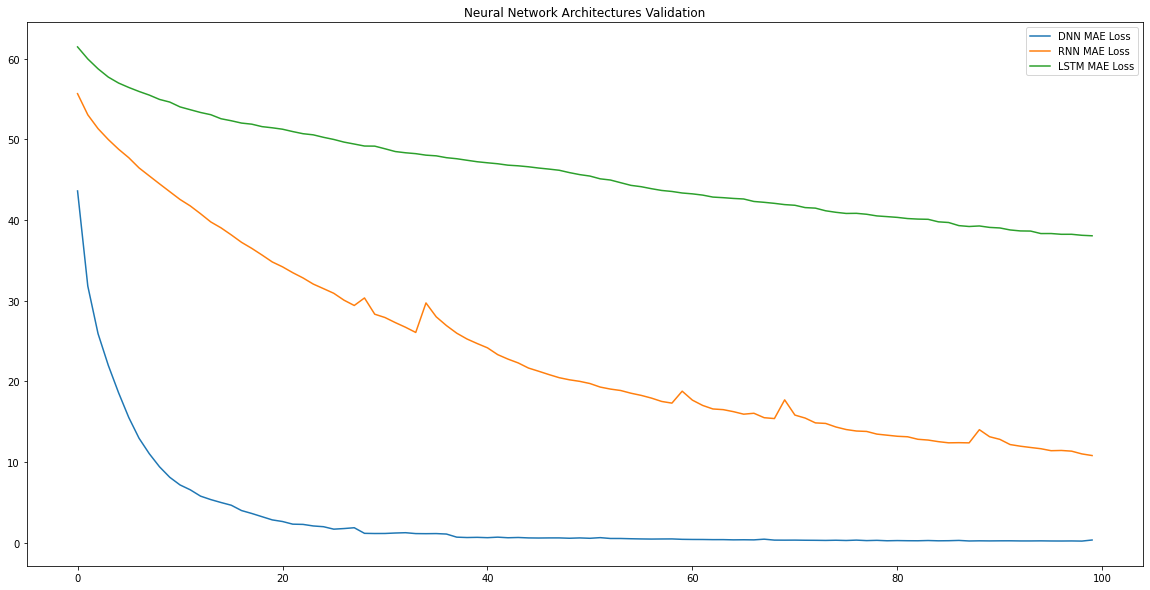

In [124]:
fix, ax = plt.subplots(figsize=(20,10))
ax.plot(dnnfft_history.epoch, np.array(dnnfft_history.history['val_loss']), label = 'DNN MAE Loss')
ax.plot(rnnfft_history.epoch, np.array(rnnfft_history.history['val_loss']), label = 'RNN MAE Loss')
ax.plot(lstmfft_history.epoch, np.array(lstmfft_history.history['val_loss']), label = 'LSTM MAE Loss')
ax.set_title('Neural Network Architectures Validation')
ax.legend()

1/1 [==============================] - 0s 19ms/step
[ -1.7599707    0.0413717   -5.2923846  -19.791481   -17.35456
   7.9502573    1.90654      2.3622005    2.762919    -7.4059496
  26.849174    16.046371    -2.0481884   -7.7091465    0.22103378
  -1.6979157   -3.285668     0.04792249  -3.0463085   -5.9559946
  -6.724718     6.336929     3.1780572    4.502323     3.3983383
   0.28366712   1.503059    -0.25959876   1.7968702   -1.2097127
   1.7757792   -1.6433516    1.1473967    1.5801547   -1.2988431
  -1.5048072    1.4663284   -3.4657059   -0.7311467   -1.7848213
  -2.1893296    2.3706374    3.0673962   -1.098969     1.0022097
  -0.9746912   -1.4856402    0.53445756   2.7039587   -0.05465139
  -0.09733234  -4.4376426   -1.1229584    2.098718     4.2126374
   0.6453451    0.06713052   0.74942046   0.046133    -1.7675692
   2.6365242   -2.6753833   -0.17641556   2.5869384   -0.41000623
  -0.41980004  -1.0558141   -4.08933      1.5522391    1.9718297
  -0.32729656  -0.93730223  -0.680477

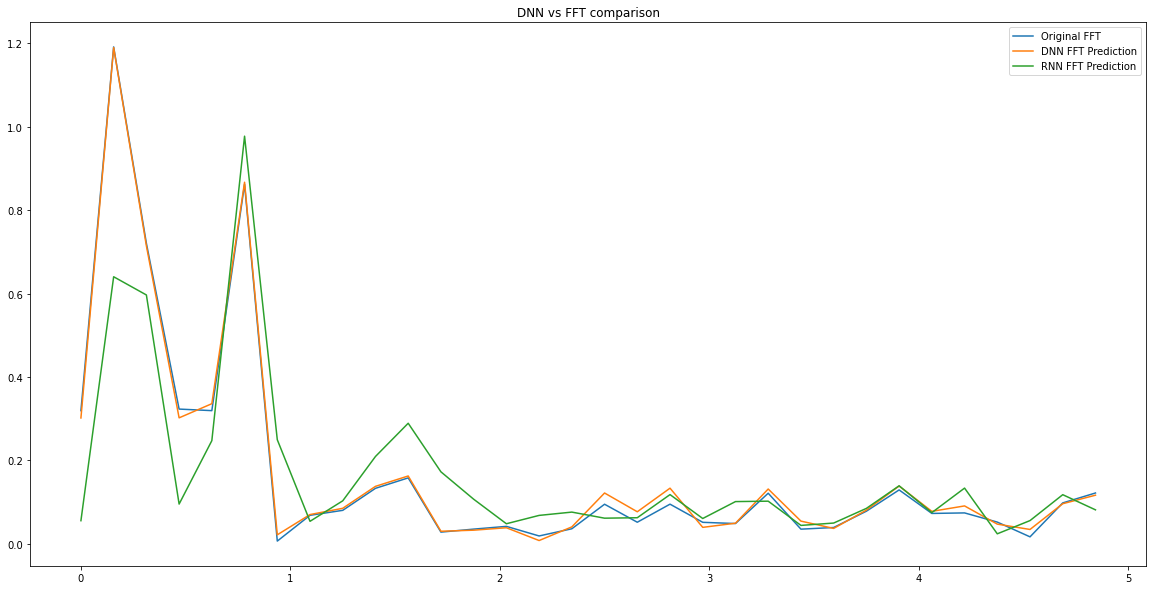

In [128]:
fftin = np.zeros((1,2*NFFT))
fftin[:,0::2]=ypn[0:NFFT]
fftout = dnnfft_model.predict(fftin).flatten()
fftout = fftout[0::2] + 1j*fftout[1::2]

fftout_rnn = rnnfft_model.predict(fftin).flatten()
print(fftout_rnn)
fftout_rnn = fftout_rnn[0::2] + 1j*fftout_rnn[1::2]
print(fftout_rnn)

fix, ax = plt.subplots(figsize=(20,10))
ax.plot(xf, 2.0/N * np.abs(yf[:N//2]), label = 'Original FFT ')
ax.plot(xf, 2.0/NFFT * np.abs(fftout[0:NFFT//2]), label = 'DNN FFT Prediction')
ax.plot(xf, 2.0/NFFT * np.abs(fftout_rnn[0:NFFT//2]), label = 'RNN FFT Prediction')
ax.set_title('DNN vs FFT comparison')
ax.legend()


Compare FFT & NN Outputs for random data


32/32 [==============================] - 0s 805us/step
Neural Network SNR compare to SciPy FFT:  23.315084529474166


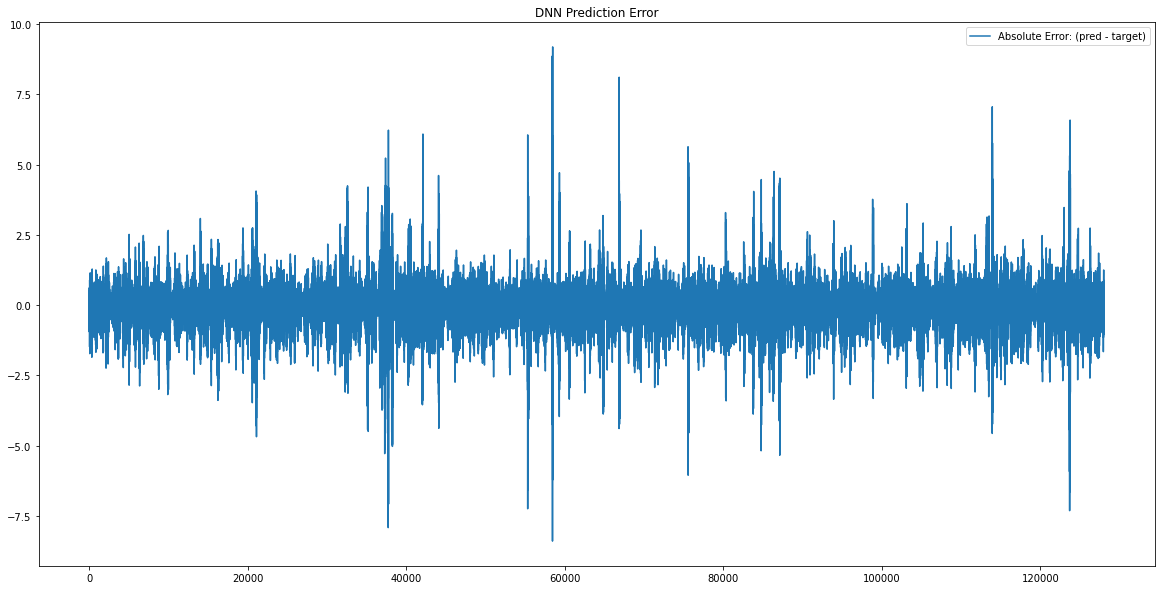

In [123]:
test_data = np.random.normal(0,1,(1000, NFFT*2))
test_labels = np.random.normal(0,1,(1000, NFFT*2))
for el in range(1000):
  fftin = test_data[el,0::2] + 1j*test_data[el,1::2]
  test_labels[el,0::2]=scipy.fftpack.fft(fftin).real
  test_labels[el,1::2]=scipy.fftpack.fft(fftin).imag

dnn_out = dnnfft_model.predict(test_data).flatten()
keras_dnn_err = test_labels.flatten() - dnn_out

fix, ax = plt.subplots(figsize=(20,10))
ax.plot(keras_dnn_err, label = 'Absolute Error: (pred - target)')
ax.set_title('DNN Prediction Error')
ax.legend()

dnn_fft_mse = 10*np.log10(np.mean(pow(np.abs(keras_dnn_err),2)))
labels_sigpow = 10*np.log10(np.mean(pow(np.abs(test_labels.flatten()),2)))
print("Neural Network SNR compare to SciPy FFT: ", labels_sigpow - dnn_fft_mse)